chargement de la data

In [133]:
!pip install --upgrade scikit-learn

lien de la base de donnée : https://www.kaggle.com/datasets/altruistdelhite04/loan-prediction-problem-dataset

In [134]:
# importer les packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import pickle

In [135]:
#lire la base de données
df=pd.read_csv('train.csv')

In [136]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [137]:
df.shape

(614, 13)

In [138]:
# voir les valeurs manquantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [139]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [140]:
#par ordre croissant
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

In [141]:
#statistiques des variables numeriques
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [142]:
#statistique des variables categoriques
df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001002,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [143]:
for i,c in enumerate(df.dtypes):
  print(i,c)

0 object
1 object
2 object
3 object
4 object
5 object
6 int64
7 float64
8 float64
9 float64
10 float64
11 object
12 object


In [144]:
#on va diviser la base de données en deux parties cat et num

# Renseigner les valeurs manquantes
cat_data=[]
num_data=[]
for i,c in enumerate(df.dtypes):
  if c==object:
    cat_data.append(df.iloc[:,i])
  else:
    num_data.append(df.iloc[:,i])
cat_data=pd.DataFrame(cat_data).transpose()
num_data=pd.DataFrame(num_data).transpose()

In [145]:
# Pour les variables catégoriques on va remplacer les valeurs manquantes par les valeurs qui se repetent le plus
cat_data=cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))
cat_data.isnull().sum().any()

False

In [146]:
# Pour les variables numériques on va remplacer les valeurs manquantes par la valeur précedente de la meme colonne
num_data.fillna(method='bfill',inplace=True)
num_data.isnull().sum().any()

False

In [147]:
# Tranformer la colonne target
target_value={'Y':1,'N':0}
target=cat_data['Loan_Status']
cat_data.drop('Loan_Status',axis=1,inplace=True)
target=target.map(target_value)
target

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

In [148]:
# Remplacer les valeurs catégoriques par des valeurs numérique 0,1,2...
le=LabelEncoder()
for i in cat_data:
  cat_data[i]=le.fit_transform(cat_data[i])
cat_data
#le 1 pour les valeus qui se repetent le plus

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,0,1,0,0,0,0,2
1,1,1,1,1,0,0,0
2,2,1,1,0,0,1,2
3,3,1,1,0,1,0,2
4,4,1,0,0,0,0,2
...,...,...,...,...,...,...,...
609,609,0,0,0,0,0,0
610,610,1,1,3,0,0,0
611,611,1,1,1,0,0,2
612,612,1,1,2,0,0,2


In [149]:
# Supprimer loan_id
cat_data.drop('Loan_ID',axis=1,inplace=True)

In [150]:
# Concatener cat_Data et num_data et spécifier la colonne target
X=pd.concat([cat_data,num_data],axis=1)
#pour les données independantes
y=target
#y pour la variable dependante

In [151]:
# va commencer par la variable target
target.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

Analyse exploratoire

In [152]:
# la base de données utilisée
df=pd.concat([cat_data,num_data,target],axis=1)

In [153]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status
0,1,0,0,0,0,2,5849.0,0.0,128.0,360.0,1.0,1
1,1,1,1,0,0,0,4583.0,1508.0,128.0,360.0,1.0,0
2,1,1,0,0,1,2,3000.0,0.0,66.0,360.0,1.0,1
3,1,1,0,1,0,2,2583.0,2358.0,120.0,360.0,1.0,1
4,1,0,0,0,0,2,6000.0,0.0,141.0,360.0,1.0,1


Le pourcentage des crédits accordés est : 68.73%
Le pourcentage des crédits non accordés est : 31.27%


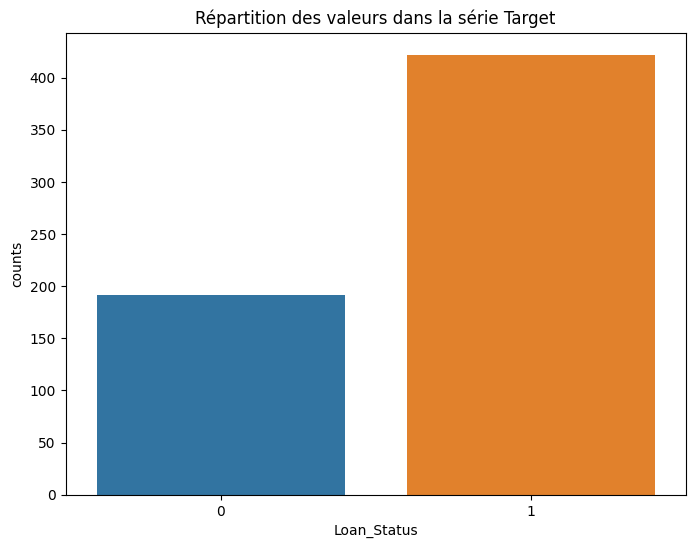

In [154]:
# Création du countplot avec Seaborn
plt.figure(figsize=(8, 6))
sns.countplot(x=target)
plt.title('Répartition des valeurs dans la série Target')
plt.xlabel('Loan_Status')
plt.ylabel('counts')

# Calcul des pourcentages
yes = target.value_counts()[1] / len(target)
no = target.value_counts()[0] / len(target)
print(f'Le pourcentage des crédits accordés est : {yes * 100:.2f}%')
print(f'Le pourcentage des crédits non accordés est : {no * 100:.2f}%')

# Affichage du graphique
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


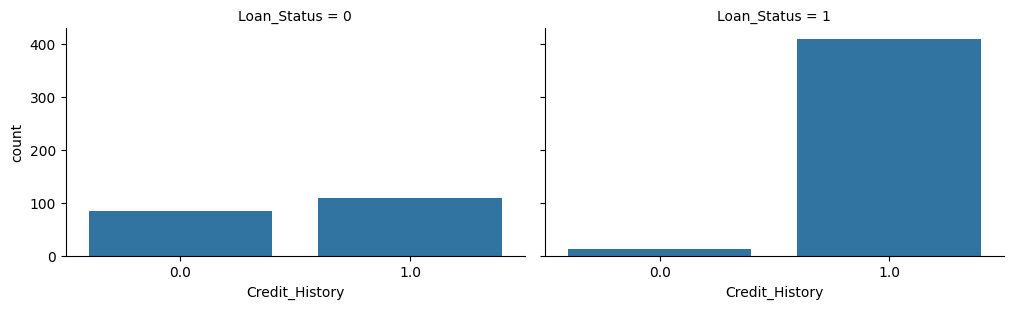

In [155]:
grid = sns.FacetGrid(df, col='Loan_Status', height=3.2, aspect=1.6)
grid.map(sns.countplot, 'Credit_History')

# Affichage du graphique
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


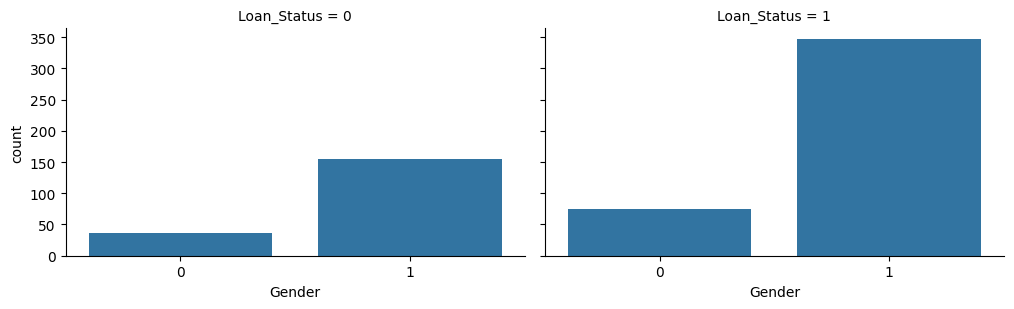

In [156]:
# Sexe
grid=sns.FacetGrid(df,col='Loan_Status',height=3.2,aspect=1.6)
grid.map(sns.countplot,'Gender')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


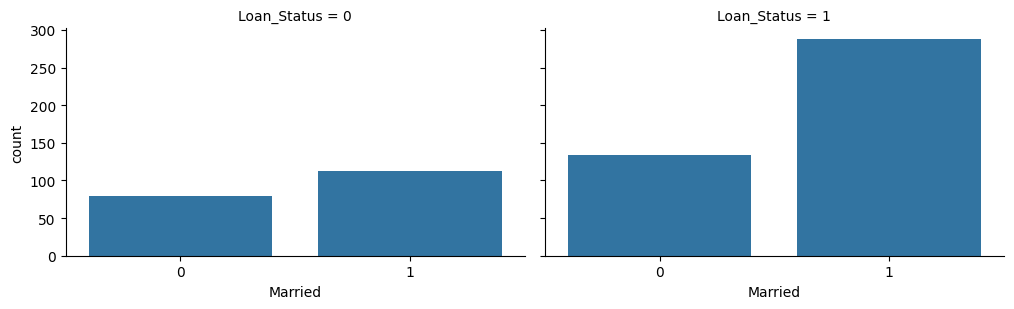

In [157]:
# situation matrimoniale
grid=sns.FacetGrid(df,col='Loan_Status',height=3.2,aspect=1.6)
grid.map(sns.countplot,'Married')

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


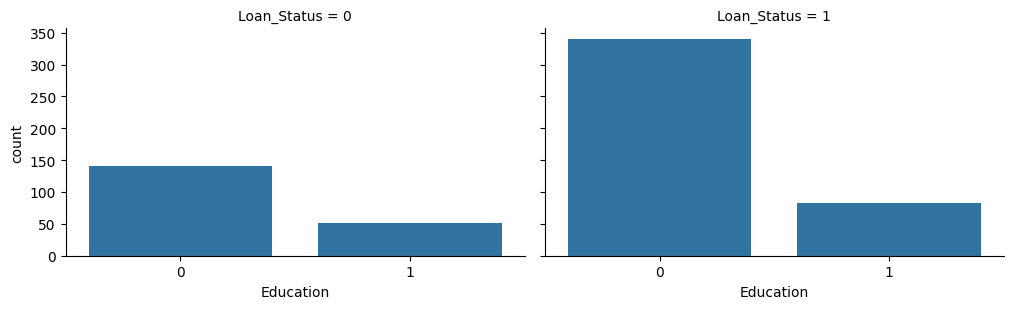

In [158]:
# Education
grid=sns.FacetGrid(df,col='Loan_Status',height=3.2,aspect=1.6)
grid.map(sns.countplot,'Education')

In [159]:
# Diviser la base de données en une base de données test et d'entrainement
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train,test in sss.split(X,y):
  X_train,X_test=X.iloc[train],X.iloc[test]
  y_train,y_test=y.iloc[train],y.iloc[test]

print('X_train taille: ', X_train.shape)
print('X_test taille: ', X_test.shape)
print('y_train taille: ', y_train.shape)
print('y_test taille: ', y_test.shape)

X_train taille:  (491, 11)
X_test taille:  (123, 11)
y_train taille:  (491,)
y_test taille:  (123,)


In [160]:
# On va appliquer tois algorithmes Logisitic Regression, KNN, DecisionTree
models={
    'LogisticRegression':LogisticRegression(random_state=42),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(max_depth=1,random_state=42)
}

# La fonction de précision
def accu(y_true,y_pred,retu=False):
  acc=accuracy_score(y_true,y_pred)
  if retu:
    return acc
  else:
    print(f'la precision du modèle est: {acc}')

#c'est la fonction d'application des modèles
def train_test_eval(models,X_train,y_train,X_test,y_test):
  for name,model in models.items():
    print(name,':')
    model.fit(X_train,y_train)
    accu(y_test,model.predict(X_test))
    print('-'*30)

train_test_eval(models,X_train,y_train,X_test,y_test)


LogisticRegression :
la precision du modèle est: 0.8536585365853658
------------------------------
KNeighborsClassifier :
la precision du modèle est: 0.6504065040650406
------------------------------
DecisionTreeClassifier :
la precision du modèle est: 0.8455284552845529
------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  options={"iprint": iprint, "gtol": tol, "maxiter": max_iter},


In [161]:
#utiliser les variables qui ont plus d'impacts

X_2=X[['Credit_History','Married','CoapplicantIncome']]

In [162]:
# Diviser la base de données en une base de données test et d'entrainement
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train,test in sss.split(X_2,y):
  X_train,X_test=X_2.iloc[train],X_2.iloc[test]
  y_train,y_test=y.iloc[train],y.iloc[test]

print('X_train taille: ', X_train.shape)
print('X_test taille: ', X_test.shape)
print('y_train taille: ', y_train.shape)
print('y_test taille: ', y_test.shape)

X_train taille:  (491, 3)
X_test taille:  (123, 3)
y_train taille:  (491,)
y_test taille:  (123,)


In [163]:
train_test_eval(models,X_train,y_train,X_test,y_test)

LogisticRegression :
la precision du modèle est: 0.8536585365853658
------------------------------
KNeighborsClassifier :
la precision du modèle est: 0.6991869918699187
------------------------------
DecisionTreeClassifier :
la precision du modèle est: 0.8455284552845529
------------------------------


In [164]:
# Appliquer la regression logisitique sur notre base de donnée
Classifier=LogisticRegression()
Classifier.fit(X_2,y)

LogisticRegression()

In [165]:
# Enregistrer le modèle
pickle.dump(Classifier,open('model.pkl','wb'))